Pre-processing the dataset to ensure a uniform distribution and limit it to 5 books.

In [72]:
from datasets import load_dataset

#loading the dataset
dataset = load_dataset("grosenthal/latin_english_translation")

In [73]:
import pandas as pd
df_train=pd.DataFrame(dataset["train"])

df_train.head()


,id,la,en,file
0,81997,post haec ambulabat Iesus in Galilaeam non eni...,"After these things, Jesus walked in Galilee: f...",final_alignments\Vulgate_Bible.json
1,65040,"Despectus tibi sum nec, qui sim, quaeris, Alex...","You scorn me, Alexis, and ask not what I am'ho...",final_alignments\Virgil_Eclogues.json
2,15899,frumenta non solum tanta multitudine iumentoru...,the corn not only was being consumed by so gre...,final_alignments\Caesar_DBG_Book6.json
3,38602,Talibus hic Poenus; sed contra Oenotria pubes ...,"Thus spoke Hannibal; but the men of Rome, on t...",final_alignments\Silius_Italicus_Punica_Book12...
4,29514,non tulit ulterius capti blasphemia monstri Vi...,"No further did Faith, the Virtues queen, bear ...",final_alignments\Prudentius_Psychomachia.json


Loading the english victorian era authorship dataset (IGNORE)

In [228]:
import chardet    

def guess_encoding(file_path):
    with open(file_path, 'rb') as file:
        # Read a portion of the file
        sample = file.read(1000000)  # You can adjust the number of bytes read as needed
        guess = chardet.detect(sample)
        return guess['encoding']

file_path = 'victorian era english/Gungor_2018_VictorianAuthorAttribution_data-train.csv'
encoding = guess_encoding(file_path)
print("Guessed Encoding:", encoding)

Guessed Encoding: ascii


In [229]:

df_train_vic = pd.read_csv(file_path, encoding='ISO-8859-1')

df_train_vic.head(10)

print(df_train_vic['author'].value_counts())


author
8     6914
26    4441
14    2696
37    2387
45    2312
21    2307
39    2266
48    1825
33    1742
19    1543
4     1483
15    1460
43    1266
38    1163
25    1159
9     1108
18    1078
42    1022
30     972
50     914
1      912
41     911
28     823
10     755
32     703
36     693
17     660
35     659
29     645
12     627
46     605
20     587
22     495
13     485
44     468
23     455
34     453
40     430
6      407
11     383
2      382
24     380
27     306
3      213
16     183
Name: count, dtype: int64


Data distribution of the latin english dataset

file
final_alignments\Vulgate_Bible.json                     32370
final_alignments\Cato_Agriculture.json                   1116
final_alignments\Tertullian_Apology.json                  977
final_alignments\Sallust_Jugurtha.json                    931
final_alignments\Velleius_Paterculus_Compendium.json      871
                                                        ...  
final_alignments\Cornelius_Nepos_Chabrias.json             14
final_alignments\Sidonius_Poems.json                       14
final_alignments\Ausonius_Conclusion.json                  11
final_alignments\Modestinus_Cupid_Asleep.json              10
final_alignments\Cornelius_Nepos_On_Kings.json              7
Name: count, Length: 271, dtype: int64


<Axes: xlabel='file'>

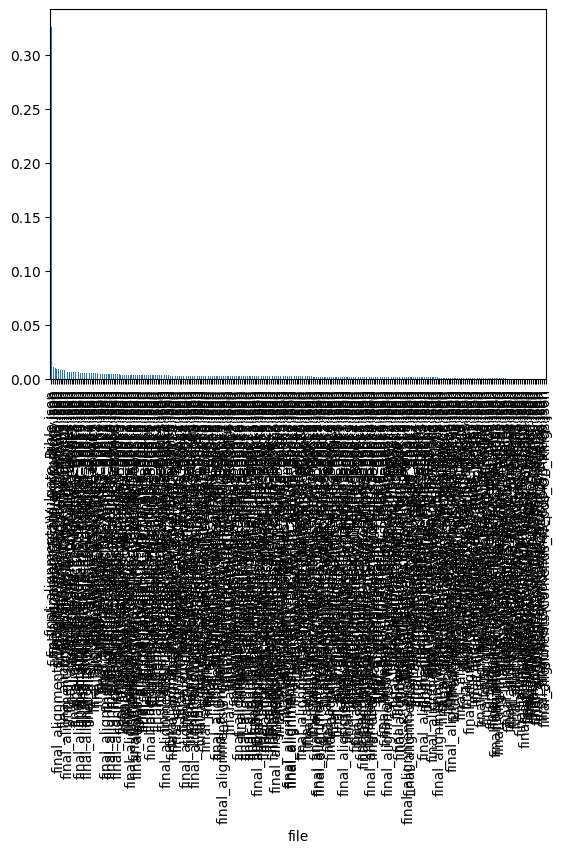

In [76]:
import matplotlib
print(df_train['file'].value_counts())

df_train['file'].value_counts(normalize=True).plot(kind='bar')

In [77]:
most_frequent_target = df_train['file'].value_counts().idxmax()

df_filtered_train = df_train[df_train['file'] != most_frequent_target]
print(df_filtered_train['file'].value_counts().head(10))

file
final_alignments\Cato_Agriculture.json                   1116
final_alignments\Tertullian_Apology.json                  977
final_alignments\Sallust_Jugurtha.json                    931
final_alignments\Velleius_Paterculus_Compendium.json      871
final_alignments\Apuleius_Apologia.json                   818
final_alignments\Catullus_Poems.json                      812
final_alignments\Pliny_Younger_Panegyricus.json           798
final_alignments\Cicero_Philippic_2.json                  791
final_alignments\Quintus_Curtius_Alexander_Book4.json     669
final_alignments\Tibullus_Elegies.json                    639
Name: count, dtype: int64


In [78]:
print(df_filtered_train['en'].head())

1    You scorn me, Alexis, and ask not what I am'ho...
2    the corn not only was being consumed by so gre...
3    Thus spoke Hannibal; but the men of Rome, on t...
4    No further did Faith, the Virtues queen, bear ...
5    Tiberius Gracchus, the son of Tiberius Gracchu...
Name: en, dtype: object


Filtering the data to make it uniform distribution

<Axes: xlabel='file'>

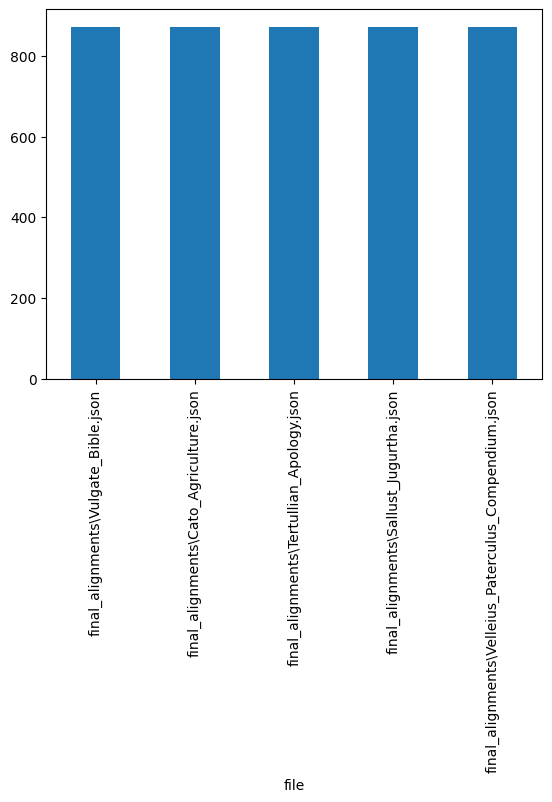

In [79]:
def filter_for_uniform_distribution(df, target_column, num_targets=10):
    # select num_targets as most frequent n targets
    top_targets = df[target_column].value_counts().nlargest(num_targets).index

    # Filter the dataframe for only the top targets
    filtered_df = df[df[target_column].isin(top_targets)]

    # Find the minimum count of the top targets
    min_count = filtered_df[target_column].value_counts().min()

    # Create a uniformly distributed dataframe
    uniform_df = pd.DataFrame()
    for target in top_targets:
        target_df = filtered_df[filtered_df[target_column] == target].sample(min_count)
        uniform_df = pd.concat([uniform_df, target_df])

    return uniform_df

df_filtered_train= filter_for_uniform_distribution(df_train, "file", 5 )
df_filtered_train['file'].value_counts(normalize=False).plot(kind='bar')


*Augmenting the dataset to increase its amount*

- Back translation

In [98]:
import translators as ts
import pandas as pd
from tqdm.notebook import tqdm  # Using notebook version of tqdm for better compatibility with notebooks
import time 
LANG = 'fr'

def back_translate(row):
    try:
        time.sleep(0.5)

        # Translate from English to Italian and back to English
        intermediate_translation_eng = ts.translate_text(row['en'], to_language=LANG, translator='google')
        back_translated_text_eng = ts.translate_text(intermediate_translation_eng, to_language='en', translator='google')
        
        # Translate from Latin to Italian and back to Latin
        intermediate_translation_la=ts.translate_text(row['la'], to_language=LANG, translator='google')
        back_translated_text_la = ts.translate_text(intermediate_translation_la, to_language='la', translator='google')
        
        new_id= row["id"]+(2*871) #so the id's still map (871 is the size of the # of samples per data)

        return [new_id, back_translated_text_la, back_translated_text_eng, row['file']]
    except Exception as e:
        print(f"Error in translation: {e}")
        time.sleep(0.5)
        return [row["id"], row['la'], row['en'], row['file']]



df_sample = df_filtered_train[:2]  # Adjust the sample size as needed

tqdm.pandas(desc='Back Translation Progress')
translated_data_train = df_sample.progress_apply(back_translate, axis=1)


translated_df_train = pd.DataFrame(translated_data_train.tolist(), columns=['id', 'la', 'en', 'file'])

translated_df_train.to_csv('back_translated_dataset_eng.csv', index=False)

print(translated_df_train.head().to_csv())

Back Translation Progress:   0%|          | 0/2 [00:00<?, ?it/s]

,id,la,en,file
0,102089,"Fratres mei, et os meum et caro mea, cur ego novissimo ad reducere regem?","You are my brothers, you are my bone and my flesh, why are you the last to bring the king back?",final_alignments\Vulgate_Bible.json
1,84960,"Et vidit quod turbatus est in verbis, et putavit quod genus salutem","Who having heard, was disturbed by his saying and thought with herself what way of saluting it should be.",final_alignments\Vulgate_Bible.json


In [81]:
print(df_filtered_train.head().to_csv())

,id,la,en,file
26760,100347,fratres mei vos os meum et caro mea vos quare novissimi reducitis regem,"You are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,83218,quae cum vidisset turbata est in sermone eius et cogitabat qualis esset ista salutatio,"Who having heard, was troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,86894,tunc responderunt ei quidam de scribis et Pharisaeis dicentes magister volumus a te signum videre,"Then some of the scribes and Pharisees answered him, saying: Master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
79332,93620,victori David,in finem psalmus David,final_alignments\Vulgate_Bible.json
38923,93011,custodi igitur temet ipsum et animam tuam sollicite ne obliviscaris verborum quae viderunt oculi tui et ne excedant de corde tuo cunctis diebus vitae tuae docebis ea filio

As you can see, back translation augments the data.

In [82]:
print(pd.concat([df_filtered_train, translated_df_train], ignore_index=True))

          id                                                 la  \
0     100347  fratres mei vos os meum et caro mea vos quare ...   
1      83218  quae cum vidisset turbata est in sermone eius ...   
2      86894  tunc responderunt ei quidam de scribis et Phar...   
3      93620                                      victori David   
4      93011  custodi igitur temet ipsum et animam tuam soll...   
...      ...                                                ...   
4352   61823   Et ille quidem male consultorum poenas exsolvit.   
4353   61628  Quippe cum venientem eum temptassent insidiis ...   
4354   62013  Tulit protinus et voti et consilii sui pretium...   
4355  101218  Fratres mei, et os meum, cur ego sum ad ultimu...   
4356   84089  Et vidit quod turbatus est sermo cogitabat qua...   

                                                     en  \
0     You are my brethren, you are my bone, and my f...   
1     Who having heard, was troubled at his saying a...   
2     Then some of

In [83]:
#doubling the data size by backtranslating it all
df_sample = df_filtered_train  # Adjust the sample size as needed

tqdm.pandas(desc='Back Translation Progress')
translated_data_train = df_sample.progress_apply(back_translate, axis=1)


translated_df_train = pd.DataFrame(translated_data_train.tolist(), columns=['id', 'la', 'en', 'file'])

df_filtered_train_back_translated=pd.concat([df_filtered_train, translated_df_train])
df_filtered_train_back_translated.to_csv('back_translated_train.csv', index=False)


Back Translation Progress:   0%|          | 0/4355 [00:00<?, ?it/s]

In [86]:
#to download the dataset
!pip install openpyxl
import IPython

IPython.display.FileLink('back_translated_train.csv')



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


/Users/saifshahin/PycharmProjects/NLP-Authorship-Latin-Eng/back_translated_train.csv

In [90]:
df_filtered_train_back_translated.tail(30)

,id,la,en,file
4325,62567,"Eduxisti M. Ciceronem, lux aetatis et aetatis ...",You took a few anxious days from Marcus Cicero...,final_alignments\Velleius_Paterculus_Compendiu...
4326,62851,Non post primum extremis secundo.,"And, after this first warning, it was not time...",final_alignments\Velleius_Paterculus_Compendiu...
4327,62909,In volumine volumine.,Let me put an end to my volume with a prayer.,final_alignments\Velleius_Paterculus_Compendiu...
4328,62576,Initium eiusdem generis Milonis pulsat Hirpino...,A similar fortune has participated in a simila...,final_alignments\Velleius_Paterculus_Compendiu...
4329,62712,Quod cognomen de lege consensus universum sena...,This title of Augustus was deservedly given to...,final_alignments\Velleius_Paterculus_Compendiu...
4330,62684,Fortunam et Misericordiam Caesaris mortis ut n...,He was in line with Caesars Fortune and his cl...,final_alignments\Velleius_Paterculus_Compendiu...
4331,62708,In quibus provinciarum cum principium Scipioni...,The Roman armies had been sent in these provin...,final_alignments\Velleius_Paterculus_Compendiu...
4332,62651,Victor et cesare ad urbem aliquot domos ex præ...,"Cesare, at his victorious return to the city, ...",final_alignments\Velleius_Paterculus_Compendiu...
4333,62636,"Sed humana est inconveniens tempus fortunae, c...","But this man, innovable from human power, rece...",final_alignments\Velleius_Paterculus_Compendiu...
4334,62205,"Hoc tibi. Gracco libero, P. Scipio Africanus n...",Such were the lives and such the death of the ...,final_alignments\Velleius_Paterculus_Compendiu...


In [91]:
df_filtered_train_back_translated.head(30)

,id,la,en,file
26760,100347,fratres mei vos os meum et caro mea vos quare ...,"You are my brethren, you are my bone, and my f...",final_alignments\Vulgate_Bible.json
44402,83218,quae cum vidisset turbata est in sermone eius ...,"Who having heard, was troubled at his saying a...",final_alignments\Vulgate_Bible.json
31600,86894,tunc responderunt ei quidam de scribis et Phar...,Then some of the scribes and Pharisees answere...,final_alignments\Vulgate_Bible.json
79332,93620,victori David,in finem psalmus David,final_alignments\Vulgate_Bible.json
38923,93011,custodi igitur temet ipsum et animam tuam soll...,"Keep thyself therefore, and thy soul carefully...",final_alignments\Vulgate_Bible.json
45033,91730,anno secundo Ioas filii Ioachaz regis Israhel ...,"In the second year of Joas son of Joachaz, kin...",final_alignments\Vulgate_Bible.json
89643,86358,qui cum audissent unianimiter levaverunt vocem...,"Who having heard it, with one accord lifted up...",final_alignments\Vulgate_Bible.json
86763,73964,nam et si crucifixus est ex infirmitate sed vi...,For although he was crucified through weakness...,final_alignments\Vulgate_Bible.json
12034,84753,decretum autem exiit in proximas gentilium civ...,And there went out a decree into the neighbour...,final_alignments\Vulgate_Bible.json
22469,89601,et dixerunt ad Ioas produc filium tuum ut mori...,And they said to Joas: Bring out thy son hithe...,final_alignments\Vulgate_Bible.json


In [97]:
df_sample= df_filtered_train_back_translated
tqdm.pandas(desc='Back Translation Progress')
translated_data_train_16k = df_sample.progress_apply(back_translate, axis=1)

df_filtered_train_back_translated_16k=pd.concat([df_filtered_train, translated_data_train_16k])
df_filtered_train_back_translated_16k.to_csv("translated_data_train_16k")


Back Translation Progress:   0%|          | 0/8710 [00:00<?, ?it/s]

Error in translation: 503 Server Error: Service Unavailable for url: https://translate.google.com/_/TranslateWebserverUi/data/batchexecute
Error in translation: 503 Server Error: Service Unavailable for url: https://translate.google.com/_/TranslateWebserverUi/data/batchexecute
Error in translation: the JSON object must be str, bytes or bytearray, not NoneType
Error in translation: the JSON object must be str, bytes or bytearray, not NoneType
Error in translation: the JSON object must be str, bytes or bytearray, not NoneType
Error in translation: the JSON object must be str, bytes or bytearray, not NoneType
Error in translation: 503 Server Error: Service Unavailable for url: https://translate.google.com/_/TranslateWebserverUi/data/batchexecute


To remove the datapoints that are in the wrong language due to source dataset.

In [398]:
#bug in backtranslated data, not formatted correctly.
#so we will fix the bug by reformatting the data
translated_data_train_16k_no_id = [item[1:] for item in translated_data_train_16k]
print(translated_data_train_16k_no_id[0])

['Fratres mei, et os meum et caro mea, cur ego novissimo ad reducere regem?', 'You are my brothers, you are my bone and my flesh, why are you the last to bring the king back?', 'final_alignments\\Vulgate_Bible.json']


In [399]:
i=0
while i<=5:
    print(translated_data_train_16k_no_id[i])
    i+=1

['Fratres mei, et os meum et caro mea, cur ego novissimo ad reducere regem?', 'You are my brothers, you are my bone and my flesh, why are you the last to bring the king back?', 'final_alignments\\Vulgate_Bible.json']
['Et vidit quod turbatus est in verbis, et putavit quod genus salutem', 'Who having heard, was disturbed by his saying and thought with herself what way of saluting it should be.', 'final_alignments\\Vulgate_Bible.json']
['Et quidam scribae et pharisaei, professor vult te videre te ipsum', 'Then, some scribes and Pharisees answered him, saying: Master, we would see a sign of you.', 'final_alignments\\Vulgate_Bible.json']
['Victor David', 'At the end of David', 'final_alignments\\Vulgate_Bible.json']
['Custodi animam tuam et animam meam et non obliviscaris oculis vestris sollicite et non excedant corda vestra vita in vita;', 'So keep yourself carefully and your soul. Do not forget the words your eyes have seen, and do not let them get out of your heart every day of your lif

In [400]:
id, la, en, file = zip(*translated_data_train_16k)
print(en)

('You are my brothers, you are my bone and my flesh, why are you the last to bring the king back?', 'Who having heard, was disturbed by his saying and thought with herself what way of saluting it should be.', 'Then, some scribes and Pharisees answered him, saying: Master, we would see a sign of you.', 'At the end of David', 'So keep yourself carefully and your soul. Do not forget the words your eyes have seen, and do not let them get out of your heart every day of your life. You will teach them to your sons and your grandsons,', 'During the second year of Joas, the son of Joachaz, king of Israel, reigned AmaSias son of Joas, king of Judah.', 'Who before it heard, with an agreement raised their voice to God and said: Lord, you are the one who made heaven and earth, the sea and all the things that are there.', 'Because although he was crucified by weakness, he lived by the power of God. Because we are also weak in him: but we will live with him by the power of God towards you.', 'And he 

In [401]:
translated_data_train_16k_format_fix = pd.DataFrame({
    'id': id,
    'la': la,
    'en': en,
    'file': file
})
translated_data_train_16k_format_fix.head()


,id,la,en,file
0,102089,"Fratres mei, et os meum et caro mea, cur ego n...","You are my brothers, you are my bone and my fl...",final_alignments\Vulgate_Bible.json
1,84960,"Et vidit quod turbatus est in verbis, et putav...","Who having heard, was disturbed by his saying ...",final_alignments\Vulgate_Bible.json
2,88636,"Et quidam scribae et pharisaei, professor vult...","Then, some scribes and Pharisees answered him,...",final_alignments\Vulgate_Bible.json
3,95362,Victor David,At the end of David,final_alignments\Vulgate_Bible.json
4,94753,Custodi animam tuam et animam meam et non obli...,So keep yourself carefully and your soul. Do n...,final_alignments\Vulgate_Bible.json


In [402]:
df_filtered_train_back_translated_16k=pd.concat([df_filtered_train_back_translated, translated_data_train_16k_format_fix])
df_filtered_train_back_translated_16k.to_csv("translated_data_train_16k_format_fix.csv")

In [330]:

IPython.display.FileLink('translated_data_train_16k_format_fix.csv')

/Users/saifshahin/PycharmProjects/NLP-Authorship-Latin-Eng/translated_data_train_16k_format_fix.csv

In [403]:
#Size of the dataset
df_filtered_train_back_translated_16k.shape[0]

17420

In [404]:
df_filtered_train_back_translated_16k.head()

,id,la,en,file
26760,100347,fratres mei vos os meum et caro mea vos quare ...,"You are my brethren, you are my bone, and my f...",final_alignments\Vulgate_Bible.json
44402,83218,quae cum vidisset turbata est in sermone eius ...,"Who having heard, was troubled at his saying a...",final_alignments\Vulgate_Bible.json
31600,86894,tunc responderunt ei quidam de scribis et Phar...,Then some of the scribes and Pharisees answere...,final_alignments\Vulgate_Bible.json
79332,93620,victori David,in finem psalmus David,final_alignments\Vulgate_Bible.json
38923,93011,custodi igitur temet ipsum et animam tuam soll...,"Keep thyself therefore, and thy soul carefully...",final_alignments\Vulgate_Bible.json


In [405]:
#Re-setting the id parameter because its not linear and does not make sense

def reset_ids(df):
    # Assuming 'id' is the column that needs to be reset
    df['id'] = range(1, len(df) + 1)
    return df
df_filtered_train_back_translated_16k= reset_ids(df_filtered_train_back_translated_16k)
df_filtered_train_back_translated_16k.tail()

,id,la,en,file
8705,17416,Hoc nobilis familiae Cornelius Rufino bella in...,"He was jumped by a noble family, the sixth des...",final_alignments\Velleius_Paterculus_Compendiu...
8706,17417,Videbatur in viginti homines ad campanum terra...,Cicero seemed to have turned on their resentme...,final_alignments\Velleius_Paterculus_Compendiu...
8707,17418,Et in poenam.,Lepido himself paid the penalty for his reckle...,final_alignments\Velleius_Paterculus_Compendiu...
8708,17419,Cumque ad nisus exspectare et bellum ausus vir...,"Since then, at the arrival of Caesars in Egypt...",final_alignments\Velleius_Paterculus_Compendiu...
8709,17420,"Et statim tulit suffragium de publico pretium,...",The state quickly collected the fruit of its t...,final_alignments\Velleius_Paterculus_Compendiu...


In [440]:
!pip install lingua-language-detector

  Obtaining dependency information for lingua-language-detector from https://files.pythonhosted.org/packages/fb/66/8cd767527a8fc5cccfd506db42c1f733fde76d38815f3b8db99c822f53de/lingua_language_detector-2.0.1-cp310-cp310-macosx_10_7_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 15.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [441]:
from lingua import Language, LanguageDetectorBuilder

languages = [Language.ENGLISH, Language.LATIN]
detector = LanguageDetectorBuilder.from_languages(*languages).with_minimum_relative_distance(0.6).build()

def find_language_mismatches(df, latin_column, english_column, id_column):
    mismatch_ids = []

    for index, row in df.iterrows():
        latin_text = row[latin_column]
        english_text = row[english_column]

        # Detect language of the text in each column
        detected_language_latin_text = detector.detect_language_of(latin_text)
        detected_language_english_text = detector.detect_language_of(english_text)

        # Check for language mismatch and add ID to list if mismatch is found
        if detected_language_latin_text == Language.ENGLISH or detected_language_english_text == Language.LATIN:
            mismatch_ids.append(row[id_column])

    return mismatch_ids

mismatched_ids = find_language_mismatches(df_filtered_train_back_translated_16k, 'la', 'en', 'id')

In [442]:
print(mismatched_ids)

[4, 16, 26, 35, 44, 88, 92, 182, 236, 246, 256, 259, 290, 358, 393, 427, 446, 495, 520, 529, 546, 554, 575, 579, 614, 694, 696, 724, 753, 789, 827, 856, 1034, 1065, 1122, 1148, 1241, 1337, 1345, 1375, 1458, 1489, 1580, 1670, 1843, 2098, 2602, 3458, 3487, 3593, 3689, 3754, 3817, 3865, 3889, 3933, 3936, 4030, 4061, 4109, 4117, 4150, 4198, 4232, 4249, 4305, 4447, 4645, 4953, 5046, 5164, 5599, 5603, 5844, 5913, 6002, 6025, 6100, 6453, 6698, 6714, 6833, 6957, 7813, 7863, 8071, 8126, 8172, 8220, 8244, 8288, 8291, 8399, 8455, 8485, 8505, 8553, 8636, 8660, 8802, 9000, 9401, 9463, 9540, 9762, 9831, 10085, 10168, 10199, 10357, 10359, 10380, 10422, 10425, 10580, 10624, 11188, 11312, 11554, 12168, 12197, 12218, 12304, 12350, 12374, 12480, 12527, 12575, 12599, 12643, 12646, 12740, 12860, 12905, 12908, 12942, 12956, 12991, 13015, 13157, 13355, 13756, 13874, 14117, 14130, 14158, 14712, 14735, 14777, 14780, 14898, 14926, 15163, 15424, 15543, 15667, 16664, 16705, 16835, 16878, 16882, 16930, 16998, 1700

In [447]:
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [453]:
mismatchcheker= df_filtered_train_back_translated_16k.copy()
#vewing the cases to see if they are valid
def create_mismatched_df(original_df, mismatched_ids, id_column):
    # Filter the original DataFrame to keep only the rows with the specified IDs
    mismatched_df = original_df[original_df[id_column].isin(mismatched_ids)]
    return mismatched_df

mismatched_df = create_mismatched_df(mismatchcheker, mismatched_ids, 'id')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(mismatched_df)

,id,la,en,file
79332,4,victori david,in finem psalmus david,final_alignments\Vulgate_Bible.json
61675,16,victori ab erudeito david,in finem intellectus david,final_alignments\Vulgate_Bible.json
24409,26,mechnedabai sisai sarai,"and mechnedebai, sisai, sarai,",final_alignments\Vulgate_Bible.json
39426,35,deicat nunc israhel quoniam in aeternum misericordeia eius,dicat nunc israhel quoniam bonus quoniam in saeculum misericordia eius,final_alignments\Vulgate_Bible.json
44008,44,deicens domino spes mea et fortitudo mea deus meus confidam in eum,dicet domino susceptor meus es tu et refugium meum deus meus sperabo in eum,final_alignments\Vulgate_Bible.json
57935,88,cari mei et amici mei quasi contra lepram meam steterunt et vicini mei longe steterunt,amici mei et proximi mei adversus me adpropinquaverunt et steterunt et qui iuxta me erant de longe steterunt,final_alignments\Vulgate_Bible.json
43075,92,amaria melluch attus,"amaria, melluch, hattus,",final_alignments\Vulgate_Bible.json
61125,182,sulcos eius inebria multiplica fruges eius pluviis inriga eam et germini eius benedeic,rivos eius inebria multiplica genimina eius in stillicidiis eius laetabitur germinans,final_alignments\Vulgate_Bible.json
97210,236,pro victoria david canticum,in finem david psalmus,final_alignments\Vulgate_Bible.json
71180,246,iuxta est dominus contritis corde et confratquetos spiritu salvabit,iuxta est dominus his qui tribulato sunt corde et humiles spiritu salvabit,final_alignments\Vulgate_Bible.json


In [457]:
'''
4, 16, 26, 35, 44, 88, 92, 182, 236, 246, 256, 259, 290, 358, 393, 427, 446, 495, 520, 529, 546, 554, 575, 579, 614, 694, 696, 724, 753, 789, 827, 856, 4953, 5046, 5164, 5603, 5844, 5913, 6002, 6100, 6698, 6714, 6833, 7863, 8071, 8126, 8172, 8220, 8291, 8399, 8455, 8485, 8553, 9401, 9463, 9540, 10357, 11188, 11554, 12218, 12374, 12527, 12575, 12643, 12646, 12908, 14926, 15543, 16664, 16705, 16878, 16882, 16930, 16998, 17001, 17109, 117221, 17260, 17263, 17322
'''
wrong_data=[4, 16, 26, 35, 44, 88, 92, 182, 236, 246, 256, 259, 290, 358, 393, 427, 446, 495, 520, 529, 546, 554, 575, 579, 614, 694, 696, 724, 753, 789, 827, 856, 4953, 5046, 5164, 5603, 5844, 5913, 6002, 6100, 6698, 6714, 6833, 7863, 8071, 8126, 8172, 8220, 8291, 8399, 8455, 8485, 8553, 9401, 9463, 9540, 10357, 11188, 11554, 12218, 12374, 12527, 12575, 12643, 12646, 12908, 14926, 15543, 16664, 16705, 16878, 16882, 16930, 16998, 17001, 17109, 117221, 17260, 17263, 17322]


def filter_out_ids(df, ids_to_remove, id_column):
    # Filter out the rows with the specified IDs
    filtered_df = df[~df[id_column].isin(ids_to_remove)]
    return filtered_df


df_filtered_train_back_translated_16k= filter_out_ids(df_filtered_train_back_translated_16k, wrong_data, 'id')

df_filtered_train_back_translated_16k.head()



,id,la,en,file
26760,1,fratres mei vos os meum et caro mea vos quaris novissimi reducitis regem,"you are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,2,quae cum videisset turbata est in sermone eius et cogitabat qualis esset ista salutatio,"who having heard, was troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam de scribis et pharisaeis deicentes magister volumus a te signum videris,"then some of the scribes and pharisees answered him, saying: master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
86763,5,nam et si crucifixus est ex infirmitate sed vivit ex virtute dei nam et nos infirmi sumus in illo sed vivemus cum eo ex virtute dei in vobis,"for although he was crucified through weakness, yet he liveth by the power of god. for we also are weak in him: but we shall live with him by the power of god towards you.",final_alignments\Vulgate_Bible.json
12034,6,decretum autem exiit in proximas gentilium civitates suggerentibus ptolomeis ut pari modo et ipsi adversus iudaeos agerent ut satquerificarent,"and there went out a decree into the neighbouring cities of the gentiles, by the suggestion of the ptolemeans, that they also should act in like manner against the jews, to oblige them to sacrifice:",final_alignments\Vulgate_Bible.json


In [458]:
df_filtered_train_back_translated_16k= reset_ids(df_filtered_train_back_translated_16k)


In [459]:
df_filtered_train_back_translated_16k_COPY = df_filtered_train_back_translated_16k.copy()
df_filtered_train_back_translated_16k.head()

,id,la,en,file
26760,1,fratres mei vos os meum et caro mea vos quaris novissimi reducitis regem,"you are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,2,quae cum videisset turbata est in sermone eius et cogitabat qualis esset ista salutatio,"who having heard, was troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam de scribis et pharisaeis deicentes magister volumus a te signum videris,"then some of the scribes and pharisees answered him, saying: master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
86763,4,nam et si crucifixus est ex infirmitate sed vivit ex virtute dei nam et nos infirmi sumus in illo sed vivemus cum eo ex virtute dei in vobis,"for although he was crucified through weakness, yet he liveth by the power of god. for we also are weak in him: but we shall live with him by the power of god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum autem exiit in proximas gentilium civitates suggerentibus ptolomeis ut pari modo et ipsi adversus iudaeos agerent ut satquerificarent,"and there went out a decree into the neighbouring cities of the gentiles, by the suggestion of the ptolemeans, that they also should act in like manner against the jews, to oblige them to sacrifice:",final_alignments\Vulgate_Bible.json


*Pre-processing the data*

Expanding contractions

In [387]:
import subprocess

version = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
print (version.decode())

openjdk version "1.8.0_382"
IBM Semeru Runtime Open Edition (build 1.8.0_382-b05)
Eclipse OpenJ9 VM (build openj9-0.40.0, JRE 1.8.0 Mac OS X amd64-64-Bit Compressed References 20230810_763 (JIT enabled, AOT enabled)
OpenJ9   - d12d10c9e
OMR      - e80bff83b
JCL      - c4d2c2bafb based on jdk8u382-b05)


In [388]:
#pycontractions needs to be run on Java 8
import os

java_8_path= "/Library/Java/JavaVirtualMachines/ibm-semeru-open-8.jdk/Contents/Home"
os.environ['JAVA_HOME'] = java_8_path # Set JAVA_HOME to Java 8 JDK path


# Add Java 8 bin to PATH
os.environ['PATH'] = java_8_path + "/bin:" + os.environ['PATH']

version = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
print(version.decode())


openjdk version "1.8.0_382"
IBM Semeru Runtime Open Edition (build 1.8.0_382-b05)
Eclipse OpenJ9 VM (build openj9-0.40.0, JRE 1.8.0 Mac OS X amd64-64-Bit Compressed References 20230810_763 (JIT enabled, AOT enabled)
OpenJ9   - d12d10c9e
OMR      - e80bff83b
JCL      - c4d2c2bafb based on jdk8u382-b05)


In [337]:
#dependancies you need for pycontractions to work
!pip install git+https://github.com/MCFreddie777/language-check.git

!pip install pyemd
!pip install POT

  Cloning https://github.com/MCFreddie777/language-check.git to /private/var/folders/h8/scrn1qk15gb4l2s8189k30080000gn/T/pip-req-build-krri__kp
  Running command git clone --filter=blob:none --quiet https://github.com/MCFreddie777/language-check.git /private/var/folders/h8/scrn1qk15gb4l2s8189k30080000gn/T/pip-req-build-krri__kp
  Resolved https://github.com/MCFreddie777/language-check.git to commit 337493f25b5a49af0a09b0e264f306eccefaff8f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [338]:
#Expanding the english contractions
#based on wikipedia list 
#multi-semantic contractions are dealt with based on word mover's distance.
#see: https://pypi.org/project/pycontractions/

from pycontractions import Contractions
cont = Contractions('GoogleNews-vectors-negative300.bin')
cont.load_models()


In [408]:
def expand_english_contractions_in_dataframe(df):
    df['en'] = [text.lower() for text in cont.expand_texts(df['en'], precise=True)]
    return df

# Example usage
data = {
    'id': [1, 2, 3],
    'la': ['Latin text 1', 'Latin text 2', 'Latin text 3'],
    'en': ["I'd like to know how I'd done that!",
                "We're going to the zoo and I don't think I'll be home for dinner.",
                "Theyre going to the zoo and she'll be home for dinner."],
    'file': ['file1.txt', 'file2.txt', 'file3.txt']
}
df = pd.DataFrame(data)

expanded_df = expand_english_contractions_in_dataframe(df)
print(expanded_df)


   id            la                                                 en  \
0   1  Latin text 1          i would like to know how i had done that!   
1   2  Latin text 2  we are going to the zoo and i do not think i w...   
2   3  Latin text 3  they are going to the zoo and she will be home...   

        file  
0  file1.txt  
1  file2.txt  
2  file3.txt  


In [460]:
#As you can see, it used the most likely contraction expansion. 
#Now, to do this for the whole english part of the dataset:
df_filtered_train_back_translated_16k=expand_english_contractions_in_dataframe(df_filtered_train_back_translated_16k)
df_filtered_train_back_translated_16k.head()

,id,la,en,file
26760,1,fratres mei vos os meum et caro mea vos quaris novissimi reducitis regem,"you are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,2,quae cum videisset turbata est in sermone eius et cogitabat qualis esset ista salutatio,"who having heard, was troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam de scribis et pharisaeis deicentes magister volumus a te signum videris,"then some of the scribes and pharisees answered him, saying: master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
86763,4,nam et si crucifixus est ex infirmitate sed vivit ex virtute dei nam et nos infirmi sumus in illo sed vivemus cum eo ex virtute dei in vobis,"for although he was crucified through weakness, yet he liveth by the power of god. for we also are weak in him: but we shall live with him by the power of god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum autem exiit in proximas gentilium civitates suggerentibus ptolomeis ut pari modo et ipsi adversus iudaeos agerent ut satquerificarent,"and there went out a decree into the neighbouring cities of the gentiles, by the suggestion of the ptolemeans, that they also should act in like manner against the jews, to oblige them to sacrifice:",final_alignments\Vulgate_Bible.json


In [461]:
#expanding contractions in Latin
# based on these rules: https://www.thelatinlibrary.com/101/contractions.pdf
#contractions with unambigious expansions only.

import re
def expand_latin_contractions_in_dataframe(df):
    def reverse_contractions(text):
        
        #lower case        
        text=text.lower()

        # Rule 1: -re to -ris
        text = re.sub(r'(\w+)re\b', r'\1ris', text)

        # Rule 2: -ere to -erunt
        text = re.sub(r'(\w+)ere\b', r'\1erunt', text)
    
        #Rule 3: "forem, forēs," etc. to "essem, essēs," etc.
        text = re.sub(r'\bforem\b', 'essem', text)
        text = re.sub(r'\bforēs\b', 'essēs', text)
        text = re.sub(r'\bforet\b', 'esset', text)
        text = re.sub(r'\bforēmus\b', 'essēmus', text)
        text = re.sub(r'\bforētis\b', 'essētis', text)
        text = re.sub(r'\bforent\b', 'essent', text)
    
            # Rule 4: suppressing -vi- and -ve-
        text = re.sub(r'(\w+)stis\b', r'\1vistis', text)
        text = re.sub(r'(\w+)ssent\b', r'\1vissent', text)
        text = re.sub(r'(\w+)sse\b', r'\1visse', text)
        text = text.replace('nosti', 'novisti')
        text = text.replace('amavere', 'amaverunt')
        text = text.replace('noram', 'noveram')

        # Rule 5: contractions after si, nisi, num, ne
        text = re.sub(r'\b(si|nisi|num|ne) qui\b', r'\1 aliquis', text)
        text = re.sub(r'\b(si|nisi|num|ne) qua\b', r'\1 aliqua', text)
        text = re.sub(r'\b(si|nisi|num|ne) quod\b', r'\1 aliquid', text)

        # Rule 6: Shortened forms
        text = text.replace('ac', 'atque')
        text = text.replace('di', 'dei')
        text = text.replace('deum', 'deorum')
        text = text.replace('dis', 'deis')
        text = text.replace("vin'", 'visne')
        text = text.replace("scin'", 'scisne')
        text = text.replace('sīs', 'si vis')
        text = text.replace('sodēs', 'si audes')
        text = text.replace('sultis', 'si vultis')

        # Rule 7: Contractions in old poets
        text = text.replace('homost', 'homo est')
        text = text.replace('periculumst', 'periculum est')
        text = text.replace('ausust', 'ausus est')
        text = text.replace('qualist', 'qualis est')
        
        return text

    df['la'] = df['la'].apply(reverse_contractions)
    return df

    
    
data = {
    'id': [1, 2],
    'la': ['forem aliquid', 'forēs aliquid'],
    'en': ['Sample English text', 'Another English text'],
    'file': ['file1.txt', 'file2.txt']
}
df = pd.DataFrame(data)

reversed_df = expand_latin_contractions_in_dataframe(df)
print(reversed_df)
    

   id             la                    en       file
0   1  essem aliquid   Sample English text  file1.txt
1   2  essēs aliquid  Another English text  file2.txt


In [462]:
filtered_backtranslated_expanded_lowercase_17k_train_data=expand_latin_contractions_in_dataframe(df_filtered_train_back_translated_16k)
filtered_backtranslated_expanded_lowercase_17k_train_data.head()

,id,la,en,file
26760,1,fratres mei vos os meum et caro mea vos quaris novissimi reducitis regem,"you are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,2,quae cum videisset turbata est in sermone eius et cogitabat qualis esset ista salutatio,"who having heard, was troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam de scribis et pharisaeis deicentes magister volumus a te signum videris,"then some of the scribes and pharisees answered him, saying: master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
86763,4,nam et si crucifixus est ex infirmitate sed vivit ex virtute dei nam et nos infirmi sumus in illo sed vivemus cum eo ex virtute dei in vobis,"for although he was crucified through weakness, yet he liveth by the power of god. for we also are weak in him: but we shall live with him by the power of god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum autem exiit in proximas gentilium civitates suggerentibus ptolomeis ut pari modo et ipsi adversus iudaeos agerent ut satquerificarent,"and there went out a decree into the neighbouring cities of the gentiles, by the suggestion of the ptolemeans, that they also should act in like manner against the jews, to oblige them to sacrifice:",final_alignments\Vulgate_Bible.json


Stopwords 

In [463]:
#Removing stopwords from the data
#Latin stopwords from https://www.perseus.tufts.edu/hopper/stopwords
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))

latin_stopwords= ["ab, ac, ad, adhic, aliqui, aliquis, an, ante, apud, at, atque, aut, autem, cum, cur, de, deinde, dum, ego, enim, ergo, es, est, et, etiam, etsi, ex, fio, haud, hic, iam, idem, igitur, ille, in, infra, inter, interim, ipse, is, ita, magis, modo, mox, nam, ne, nec, necque, neque, nisi, non, nos, o, ob, per, possum, post, pro, quae, quam, quare, qui, quia, quicumque, quidem, quilibet, quis, quisnam, quisquam, quisque, quisquis, quo, quoniam, sed, si, sic, sive, sub, sui, sum, super, suus, tam, tamen, trans, tu, tum, ubi, uel, uero, unus, ut"]

latin_stopwords = latin_stopwords[0].split(", ")

datacopy= filtered_backtranslated_expanded_lowercase_17k_train_data.copy()

def remove_stopwords_from_df(df, latin_column, english_column, latin_sw, eng_sw):
    latin_stopwords_set = set(latin_sw)  # Convert stopwords to a set for faster lookup
    english_stopwords_set= set(eng_sw)
    
    # Update the Latin column
    for index in df.index:
        df.at[index, latin_column] = ' '.join([word for word in str(df.at[index, latin_column]).split() if word not in latin_stopwords_set])

    # Update the English column
    for index in df.index:
        df.at[index, english_column] = ' '.join([word for word in str(df.at[index, english_column]).split() if word not in english_stopwords_set])
    
    return df
    


pre_processed_17k_sw_removed= remove_stopwords_from_df(datacopy, "la", "en" ,latin_stopwords, english_stop_words)

pre_processed_17k_sw_removed.head()
#english stopwords from NLTK





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saifshahin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,la,en,file
26760,1,fratres mei vos os meum caro mea vos quaris novissimi reducitis regem,"brethren, bone, flesh, last bring back king?",final_alignments\Vulgate_Bible.json
44402,2,videisset turbata sermone eius cogitabat qualis esset ista salutatio,"heard, troubled saying thought manner salutation be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam scribis pharisaeis deicentes magister volumus a te signum videris,"scribes pharisees answered him, saying: master, would see sign thee.",final_alignments\Vulgate_Bible.json
86763,4,crucifixus infirmitate vivit virtute dei infirmi sumus illo vivemus eo virtute dei vobis,"although crucified weakness, yet liveth power god. also weak him: shall live power god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum exiit proximas gentilium civitates suggerentibus ptolomeis pari ipsi adversus iudaeos agerent satquerificarent,"went decree neighbouring cities gentiles, suggestion ptolemeans, also act like manner jews, oblige sacrifice:",final_alignments\Vulgate_Bible.json


Lemmatization

In [272]:
#for latin lemmatization, form the classical language toolkit
!pip install cltk


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [276]:
!pip install stanza


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Bug: lemmatization brings in intigers, ie victori-> victor1

In [464]:
copy_for_lemmatization_only= filtered_backtranslated_expanded_lowercase_17k_train_data.copy()
copy_for_sw_only= datacopy.copy()
copy_for_lemmatization_plus_sw= datacopy.copy()
from cltk.lemmatize.lat import LatinBackoffLemmatizer
from nltk.stem import WordNetLemmatizer

english_lemmatizer = WordNetLemmatizer()
latin_lemmatizer= LatinBackoffLemmatizer()

def lemmatize_latin(text):
    lemmatized = latin_lemmatizer.lemmatize(text.split())
    # Use regular expression to remove numbers from the lemmas
    lemmatized_words = [re.sub(r'\d+', '', lem[1]) for lem in lemmatized]
    return ' '.join(lemmatized_words)

# Function to lemmatize English text
def lemmatize_english(text):
    lemmatized_words = [english_lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

# Function to apply lemmatization to DataFrame columns
def lemmatize_columns_in_df(df, latin_column, english_column):
    # Update the Latin column
    for index in df.index:
        df.at[index, latin_column] = lemmatize_latin(str(df.at[index, latin_column]))

    # Update the English column
    for index in df.index:
        df.at[index, english_column] = lemmatize_english(str(df.at[index, english_column]))
    
    return df
pre_processed_17k_lemmatized=lemmatize_columns_in_df(copy_for_lemmatization_only,"la", "en" )

pre_processed_17k_lemmatized.head()

,id,la,en,file
26760,1,frater meus tu os meus et carus meus tu quaris novus reduco rex,"you are my brethren, you are my bone, and my flesh, why are you the last to bring back the king?",final_alignments\Vulgate_Bible.json
44402,2,qui cum videisset turbo sum in sermo is et cogito qualis sum iste salutatio,"who having heard, wa troubled at his saying and thought with herself what manner of salutation this should be.",final_alignments\Vulgate_Bible.json
31600,3,tunc respondeo is quidam de scribo et pharisaeis deicentes magister volo ab tu signum video,"then some of the scribe and pharisee answered him, saying: master, we would see a sign from thee.",final_alignments\Vulgate_Bible.json
86763,4,nam et si crucifigo sum ex infirmitas sed vivo ex virtus deus nam et nos infirmis sum in ille sed vivo cum is ex virtus deus in tu,"for although he wa crucified through weakness, yet he liveth by the power of god. for we also are weak in him: but we shall live with him by the power of god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum autem exeo in propior gentilis civitas suggero ptolomeis ut par modo et ipse adverro iudaei ago ut satquerificarent,"and there went out a decree into the neighbouring city of the gentiles, by the suggestion of the ptolemeans, that they also should act in like manner against the jews, to oblige them to sacrifice:",final_alignments\Vulgate_Bible.json


In [416]:
pre_processed_17k_lemmatized_sw= lemmatize_columns_in_df(copy_for_lemmatization_plus_sw,"la", "en" )

In [465]:
pre_processed_17k_lemmatized_sw.head()

,id,la,en,file
26760,1,frater meus tu os meus carus meus tu quaris novus reduco rex,"brethren, bone, flesh, last bring back king?",final_alignments\Vulgate_Bible.json
44402,2,videisset turbo sermo is cogito qualis sum iste salutatio,"heard, troubled saying thought manner salutation be.",final_alignments\Vulgate_Bible.json
31600,3,tunc respondeo is quidam scribo pharisaeis deicentes magister volo ab tu signum video,"scribe pharisee answered him, saying: master, would see sign thee.",final_alignments\Vulgate_Bible.json
79332,4,victor david,finem psalmus david,final_alignments\Vulgate_Bible.json
38923,5,custodei tu ipse anima tuus sollicitus obliviscaris verbum video oculus tuus excedo cor tuus cunctus deiebus vita tuus doceo is filius nepos tuus,"keep thyself therefore, thy soul carefully. forget word thy eye seen, let go thy heart day thy life. thou shalt teach thy son thy grandsons,",final_alignments\Vulgate_Bible.json


In [466]:
pre_processed_17k_sw_removed= copy_for_sw_only
pre_processed_17k_sw_removed.head()

,id,la,en,file
26760,1,fratres mei vos os meum caro mea vos quaris novissimi reducitis regem,"brethren, bone, flesh, last bring back king?",final_alignments\Vulgate_Bible.json
44402,2,videisset turbata sermone eius cogitabat qualis esset ista salutatio,"heard, troubled saying thought manner salutation be.",final_alignments\Vulgate_Bible.json
31600,3,tunc responderunt ei quidam scribis pharisaeis deicentes magister volumus a te signum videris,"scribes pharisees answered him, saying: master, would see sign thee.",final_alignments\Vulgate_Bible.json
86763,4,crucifixus infirmitate vivit virtute dei infirmi sumus illo vivemus eo virtute dei vobis,"although crucified weakness, yet liveth power god. also weak him: shall live power god towards you.",final_alignments\Vulgate_Bible.json
12034,5,decretum exiit proximas gentilium civitates suggerentibus ptolomeis pari ipsi adversus iudaeos agerent satquerificarent,"went decree neighbouring cities gentiles, suggestion ptolemeans, also act like manner jews, oblige sacrifice:",final_alignments\Vulgate_Bible.json


In [467]:
pre_processed_17k_sw_removed.to_csv('train_data_pre_processed_sw_removed.csv', index=False)
pre_processed_17k_lemmatized_sw.to_csv('train_data_pre_processed_lemmatized_sw_removed.csv', index=False)
pre_processed_17k_lemmatized.to_csv('train_data_pre_processed_lemmatized.csv', index=False)